# This does not work yet!

In [1]:
import theano
import numpy as np
import matplotlib.pylab as plt
import csv, os, random, sys
%matplotlib inline

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer
from lasagne.layers import DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

Mapped name None to device cuda0: Tesla K80
PCI Bus ID: 0000:85:00.0
Using cuDNN version 5105 on context None

theano 0.9.0dev4.dev-255aca76a09593f9806a02e53bea002a973f533e
lasagne 0.2.dev1


In [2]:
#Set seed for random numbers:
np.random.seed(1234)
lasagne.random.set_rng(np.random.RandomState(1234))

In [3]:
##Uncomment these lines to fetch the dataset
#!wget -c http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvf cifar-10-python.tar.gz

In [4]:
data_dir_cifar10 = os.path.join(".", "cifar-10-batches-py")

def one_hot(x, n):
    x = np.array(x)
    assert x.ndim == 1
    return np.eye(n)[x]

def _load_batch_cifar10(filename, dtype='float32'):
    path = os.path.join(data_dir_cifar10, filename)
    batch = np.load(path)
    data = batch['data'] / 255.0 # scale between [0, 1]
    labels = one_hot(batch['labels'], n=10) # convert labels to one-hot representation
    return data.astype(dtype), labels.astype(dtype)

def cifar10(dtype='float32', grayscale=True):
    x_train = []
    t_train = []
    for k in xrange(5):
        x, t = _load_batch_cifar10("data_batch_%d" % (k + 1), dtype=dtype)
        x_train.append(x)
        t_train.append(t)

    x_train = np.concatenate(x_train, axis=0)
    t_train = np.concatenate(t_train, axis=0)

    x_test, t_test = _load_batch_cifar10("test_batch", dtype=dtype)

    if grayscale:
        x_train = _grayscale(x_train)
        x_test = _grayscale(x_test)

    return x_train, t_train, x_test, t_test

# load data
x_train, t_train, x_test, t_test = cifar10(dtype=theano.config.floatX,grayscale=False)
labels_test = np.argmax(t_test, axis=1)

print "x_train.shape:",x_train.shape

# reshape data
x_train = x_train.reshape((x_train.shape[0], 3, 32, 32))
x_test = x_test.reshape((x_test.shape[0], 3, 32, 32))

cifar10_names = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']

x_train.shape: (50000, 3072)


In [5]:
# x_train = x_train[:256]
# t_train = t_train[:256]

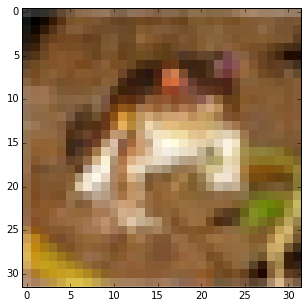

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(np.transpose(x_train[0], (1,2,0)),interpolation='none', cmap='gray');

In [7]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, DenseLayer, MaxPool2DLayer, Upscale2DLayer
from lasagne.layers import ConcatLayer, DropoutLayer, ReshapeLayer, TransposedConv2DLayer

In [8]:
input_data = T.tensor4('cifar10')
input_var_ex = T.ivector('input_var_ex')

inshape = (None, 3, 32,32)
numhidden = 2
num_classes = 10

def ConvFactory(data, num_filter, filter_size, stride=1, pad=(0, 0), nonlinearity=lasagne.nonlinearities.rectify):
    data = lasagne.layers.batch_norm(Conv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size,
        stride=stride, pad=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

def DownsampleFactory(data, ch_3x3):
    conv = ConvFactory(data=data, filter_size=(3, 3), stride=(2, 2), num_filter=ch_3x3, pad=(1, 1))
    pool = Pool2DLayer(data, pool_size=3, stride=(2, 2), pad=(1, 1), mode='max')
    concat = ConcatLayer([conv, pool])
    return concat

def SimpleFactory(data, ch_1x1, ch_3x3):
    conv1x1 = DeConvFactory(data=data, filter_size=(1, 1), pad=(0, 0), num_filter=ch_1x1)
    conv3x3 = DeConvFactory(data=data, filter_size=(3, 3), pad=(1, 1), num_filter=ch_3x3) 
    concat = ConcatLayer([conv1x1, conv3x3])
    return concat

def DeConvFactory(data, num_filter, filter_size, output_size=None, stride=1, pad=(0, 0), nonlinearity=lasagne.nonlinearities.rectify):
    data = lasagne.layers.batch_norm(TransposedConv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size, stride=stride, crop=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu'),
        output_size=output_size))
    return data

def UpsampleFactory(data, ch_3x3):
    conv = DeConvFactory(data=data, filter_size=2, stride=2, num_filter=ch_3x3, pad='valid')
    pool = Upscale2DLayer(data, scale_factor=2)
    concat = ConcatLayer([conv, pool])
    return concat



net = InputLayer(shape=inshape, input_var=input_data[input_var_ex])
print net.output_shape
l_in = net


net = ConvFactory(data=net, filter_size=(3,3), pad=(1,1), num_filter=96)
print net.output_shape
net = SimpleFactory(net, 32, 32)
print net.output_shape
net = SimpleFactory(net, 32, 48)
print net.output_shape
net = DownsampleFactory(net, 80)
print net.output_shape
net = SimpleFactory(net, 112, 48)
print net.output_shape
net = SimpleFactory(net, 96, 64)
print net.output_shape
net = SimpleFactory(net, 80, 80)
print net.output_shape
net = SimpleFactory(net, 48, 96)
print net.output_shape
net = DownsampleFactory(net, 96)
print net.output_shape
net = SimpleFactory(net, 176, 160)
print net.output_shape
net = SimpleFactory(net, 176, 160)
print net.output_shape

net_before_hidden = net

##########

net = FlattenLayer(net)  
net = lasagne.layers.DenseLayer(net, num_units=numhidden,
                                     W=lasagne.init.GlorotUniform(),
                                     nonlinearity=None)
l_hidden = net

print net.output_shape


numfilters = 336
size = 8
net = lasagne.layers.DenseLayer(net, num_units=numfilters*size*size,
                                     W=lasagne.init.GlorotUniform(),
                                     nonlinearity=None)

net = ReshapeLayer(net, ([0],numfilters,size,size))
print net.output_shape

##########

net = SimpleFactory(net, 176, 160)
print net.output_shape
net = SimpleFactory(net, 176, 160)
print net.output_shape
net = UpsampleFactory(net, 96)
print net.output_shape
net = SimpleFactory(net, 48, 96)
print net.output_shape
net = SimpleFactory(net, 80, 80)
print net.output_shape
net = SimpleFactory(net, 96, 64)
print net.output_shape
net = SimpleFactory(net, 112, 48)
print net.output_shape
net = UpsampleFactory(net, 80)
print net.output_shape
net = SimpleFactory(net, 32, 48)
print net.output_shape
net = SimpleFactory(net, 32, 32)
print net.output_shape

net = DeConvFactory(net, filter_size=(3,3), pad=1, num_filter=3)
print net.output_shape

l_out = net

(None, 3, 32, 32)
(None, 96, 32, 32)
(None, 64, 32, 32)
(None, 80, 32, 32)
(None, 160, 16, 16)
(None, 160, 16, 16)
(None, 160, 16, 16)
(None, 160, 16, 16)
(None, 144, 16, 16)
(None, 240, 8, 8)
(None, 336, 8, 8)
(None, 336, 8, 8)
(None, 2)
(None, 336, 8, 8)
(None, 336, 8, 8)
(None, 336, 8, 8)
(None, 432, 16, 16)
(None, 144, 16, 16)
(None, 160, 16, 16)
(None, 160, 16, 16)
(None, 160, 16, 16)
(None, 240, 32, 32)
(None, 80, 32, 32)
(None, 64, 32, 32)
(None, 3, 32, 32)


In [9]:
target_var = T.matrix('targets')

prediction = lasagne.layers.get_output(l_out)
#prediction = prediction.clip(0,1)
hidden = lasagne.layers.get_output(l_hidden)

#define how to make prediction
ae_reconstruct = theano.function(
    inputs=[input_var_ex],
    outputs=prediction,
    givens={input_data: x_train}
)

#define how to output embedding
ae_embed = theano.function(
    inputs=[input_var_ex],
    outputs=lasagne.layers.get_output(l_hidden),
    givens={input_data: x_train}
)

ae_reconstruct_test = theano.function(
    inputs=[input_var_ex],
    outputs=prediction,
    givens={input_data: x_test}
)

/u/cohenjos/.local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/u/cohenjos/.local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/u/cohenjos/.local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [10]:
batch_size = 128
ae_embedding = np.array([])
for i in range(0,len(x_train),batch_size):
    ae_embedding = np.append(ae_embedding, ae_embed(range(i,min(i+batch_size,len(x_train)))))

ae_embedding = ae_embedding.reshape((len(x_train), numhidden))

/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


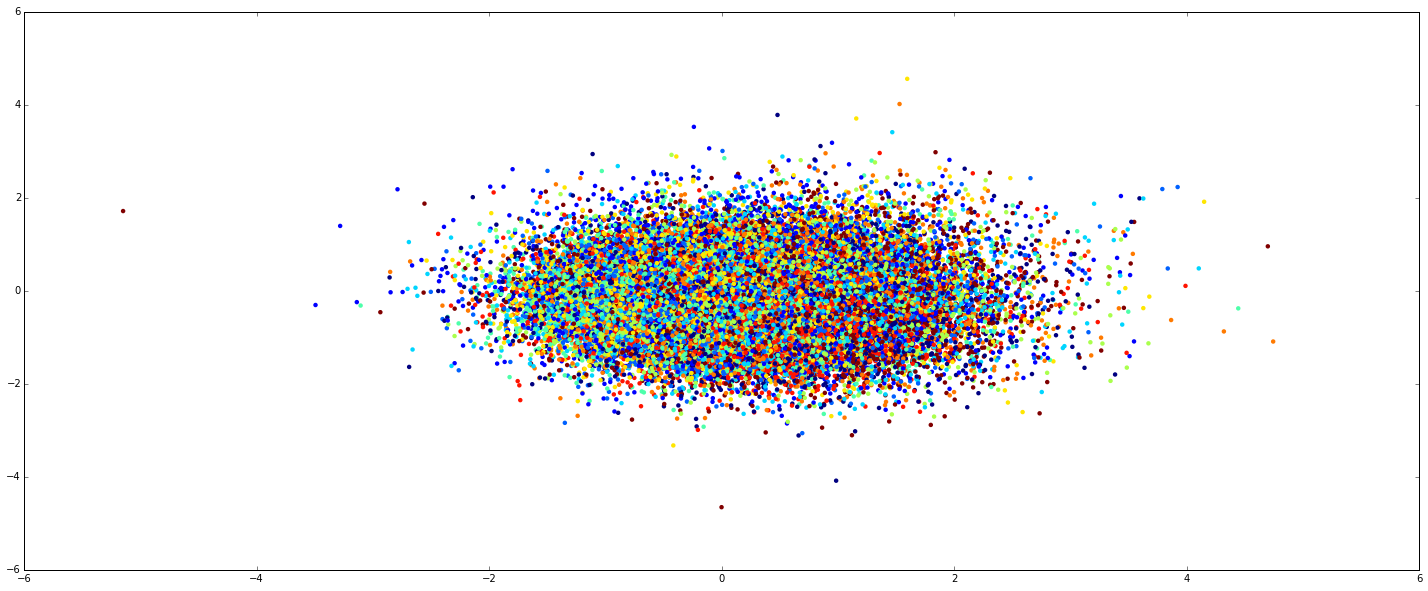

In [11]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(ae_embedding[:, 0], ae_embedding[:, 1], lw=0,c=np.argmax(t_train, axis=1));

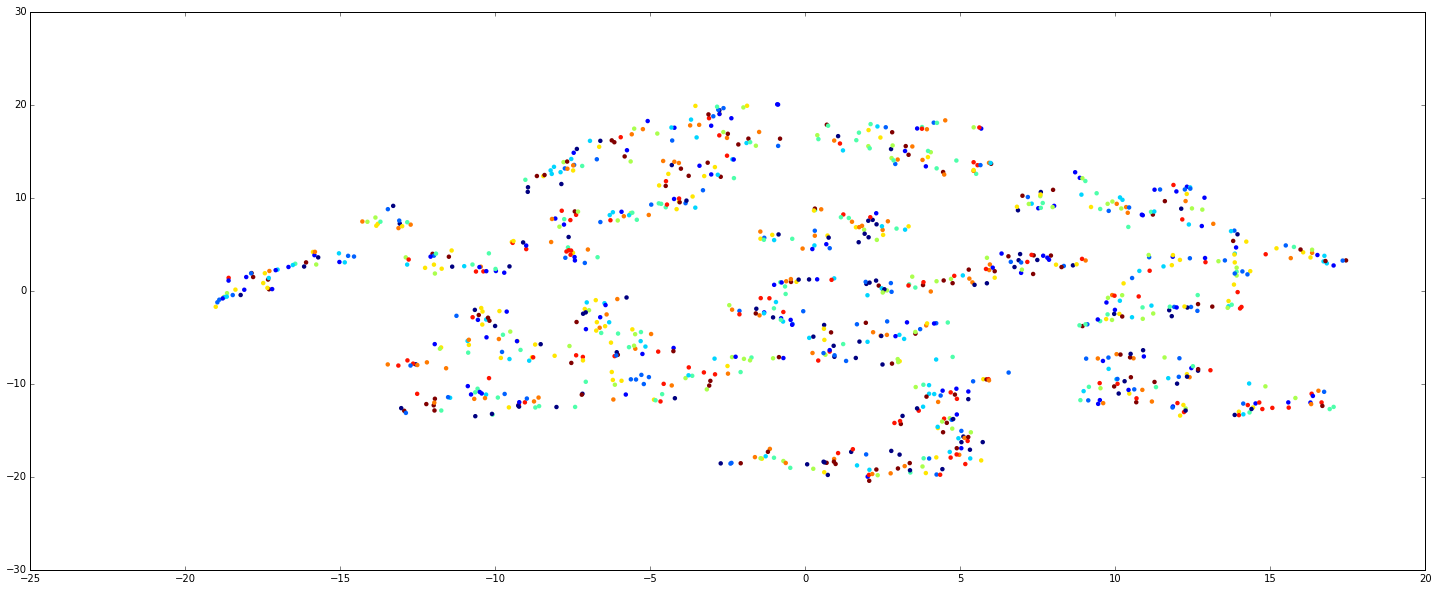

In [12]:
import sklearn.manifold
coor_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(ae_embedding[:1000])
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(coor_tsne[:, 0], coor_tsne[:, 1], lw=0, c=np.argmax(t_train, axis=1)[:1000]);

In [13]:
# create train functions 
lr = theano.shared(np.array(0., dtype=theano.config.floatX))

params_ae = lasagne.layers.get_all_params(l_out, trainable=True)

target_var = T.ivector('target')
rloss = lasagne.objectives.squared_error(prediction,input_data[input_var_ex]).mean()

updates_ae = lasagne.updates.adam(rloss, params_ae, learning_rate=lr)
f_train_ae = theano.function([input_var_ex], 
                          [rloss],
                          updates=updates_ae,
                          givens={input_data: x_train},
                          allow_input_downcast=True)

In [14]:
f_train_ae([0,1])

[array(0.45549312233924866, dtype=float32)]

In [15]:
lr.set_value(0.0001)
batch_size = 64
print "batch_size",batch_size

best_valid_error = 9999999.

for j in range(100):
    
    batch_err = []  
    
    # shuffle batches
    todo = range(len(x_train))
    random.shuffle(todo)
    
    for i in range(0,len(x_train),batch_size):
        examples = todo[i:i+batch_size]
        err = f_train_ae(examples)
        batch_err.append(err)
        
    err_result = np.asarray(batch_err).mean(axis=0)
    
    
    ### Test error
    ae_reconstruction = np.array([])
    for i in range(0,len(x_test),batch_size):
        ae_reconstruction = np.append(ae_reconstruction, ae_reconstruct_test(range(i,min(i+batch_size,len(x_test)))))

    ae_reconstruction = ae_reconstruction.reshape((len(x_test), 3, 32, 32))
    valid_error = ((ae_reconstruction - x_test)**2).mean()
    
    best_valid_error = min(best_valid_error,valid_error)
    
    if j % 1 == 0:    
        print j, err_result, valid_error, best_valid_error


batch_size 64
0 [ 0.06986681] 0.052237690509 0.052237690509
1 [ 0.04810907] 0.0459167816699 0.0459167816699
2 [ 0.04380099] 0.0427982591356 0.0427982591356
3 [ 0.04131442] 0.0409199718901 0.0409199718901
4 [ 0.03990288] 0.0398533437901 0.0398533437901
5 [ 0.03895519] 0.0388985296167 0.0388985296167
6 [ 0.03844794] 0.038374992325 0.038374992325
7 [ 0.03804174] 0.0379892644964 0.0379892644964
8 [ 0.03775412] 0.0377369520109 0.0377369520109
9 [ 0.03757781] 0.0375177053411 0.0375177053411
10 [ 0.03737445] 0.0372378045794 0.0372378045794
11 [ 0.03712418] 0.0370620840206 0.0370620840206
12 [ 0.03681912] 0.0368039054676 0.0368039054676
13 [ 0.0364612] 0.0364606210375 0.0364606210375
14 [ 0.03612832] 0.0359684049533 0.0359684049533
15 [ 0.03586126] 0.0356165370291 0.0356165370291
16 [ 0.03558053] 0.035436452996 0.035436452996
17 [ 0.03543582] 0.0353273847684 0.0353273847684
18 [ 0.03529894] 0.0353235463123 0.0353235463123
19 [ 0.03519391] 0.0352332652378 0.0352332652378
20 [ 0.03516321] 0.0351

In [16]:
batch_size = 128
ae_embedding = np.array([])
for i in range(0,len(x_train),batch_size):
    ae_embedding = np.append(ae_embedding, ae_embed(range(i,min(i+batch_size,len(x_train)))))

ae_embedding = ae_embedding.reshape((len(x_train), numhidden))

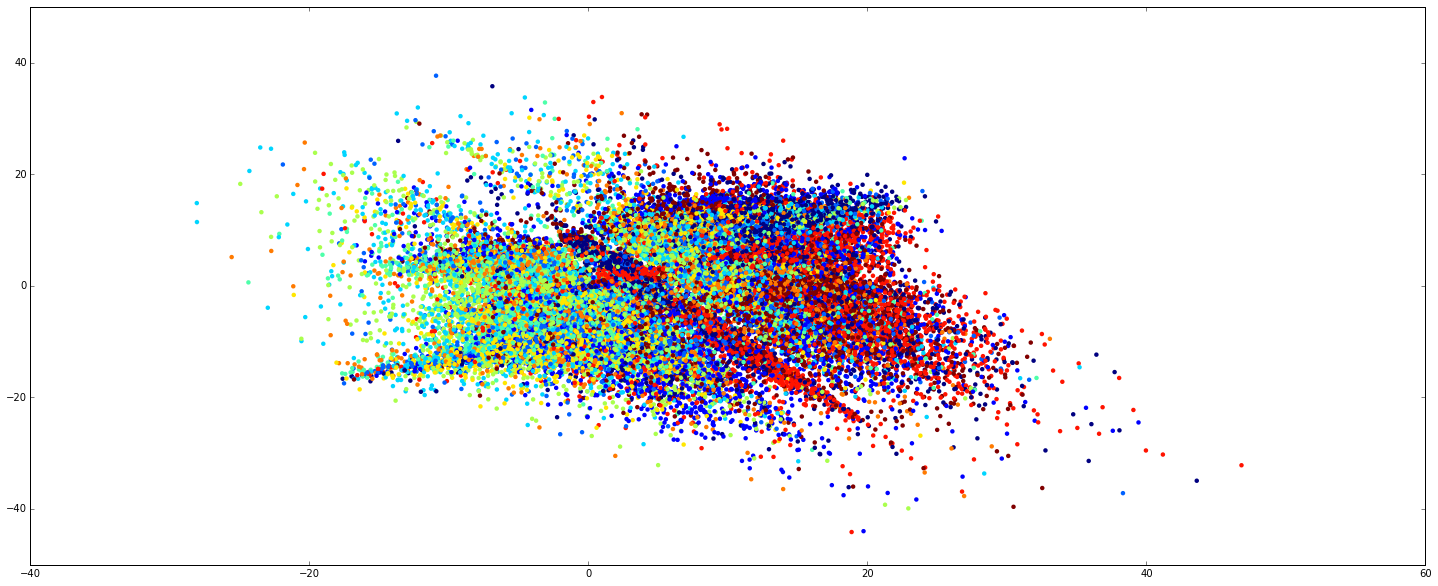

In [17]:
# view first two dimensions
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(ae_embedding[:, 0], ae_embedding[:, 1], lw=0,c=np.argmax(t_train, axis=1));

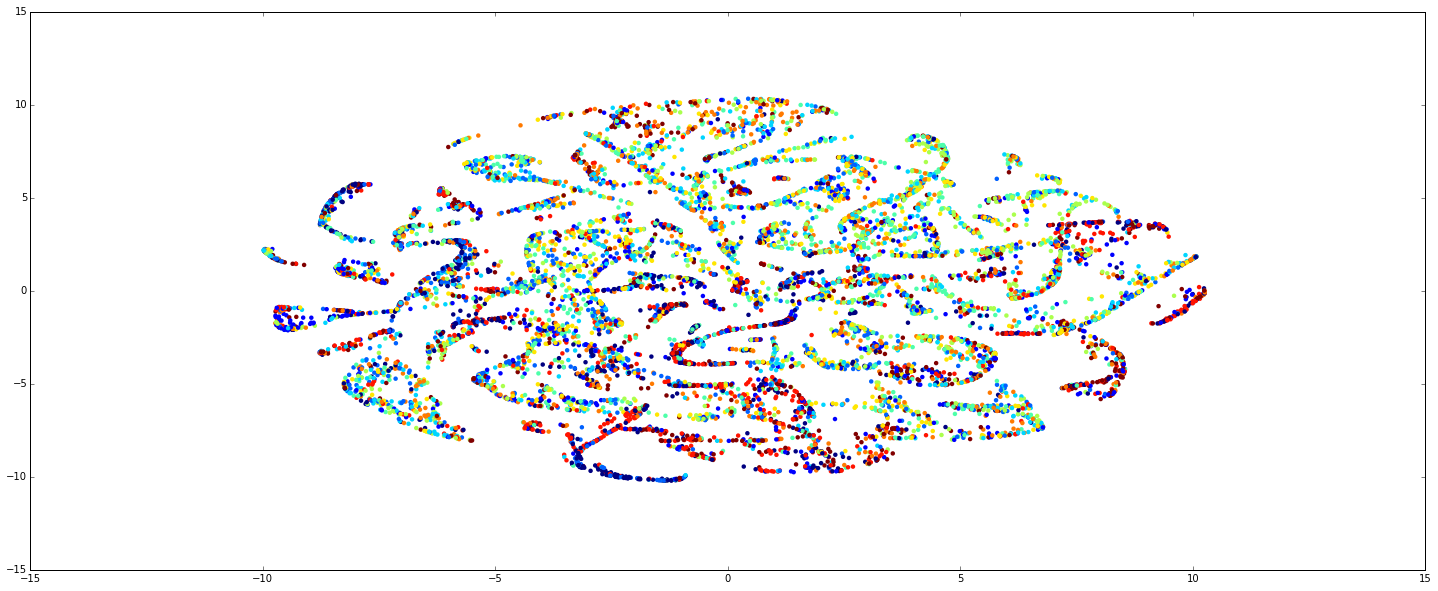

In [18]:
import sklearn.manifold
coor_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(ae_embedding[:10000])
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(coor_tsne[:, 0], coor_tsne[:, 1], lw=0, c=np.argmax(t_train, axis=1)[:10000]);

In [19]:
ae_reconstruction = ae_reconstruct(range(0,batch_size))

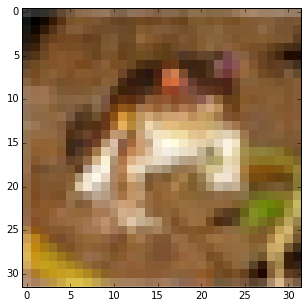

In [20]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(x_train[0], (1,2,0)),interpolation='none', cmap='gray');

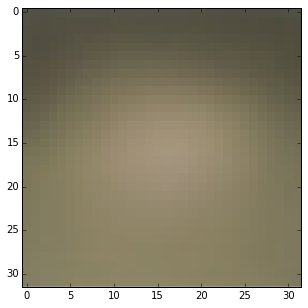

In [21]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(ae_reconstruction[0], (1,2,0)),interpolation='none', cmap='gray');

In [22]:
ae_reconstruction = ae_reconstruct_test(range(0,batch_size))

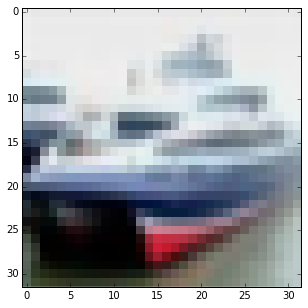

In [23]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(x_test[1], (1,2,0)),interpolation='none', cmap='gray');

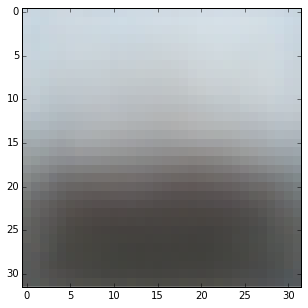

In [24]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(np.transpose(ae_reconstruction[1], (1,2,0)),interpolation='none', cmap='gray');